# Cluster Analysis

### Task Description
To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

In [1]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Data Prep

In [2]:
df_charging_sessions = pd.read_csv("charging_sessions_preprocessed.csv",  parse_dates=['connectionTime','disconnectTime','doneChargingTime']);
print(df_charging_sessions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   66450 non-null  object             
 1   connectionTime       66450 non-null  datetime64[ns, UTC]
 2   disconnectTime       66450 non-null  datetime64[ns, UTC]
 3   doneChargingTime     66450 non-null  datetime64[ns, UTC]
 4   kWhDelivered         66450 non-null  float64            
 5   sessionID            66450 non-null  object             
 6   siteID               66450 non-null  int64              
 7   spaceID              66450 non-null  object             
 8   stationID            66450 non-null  object             
 9   userID               49187 non-null  float64            
 10  userInputs           49187 non-null  object             
 11  totalConnectionTime  66450 non-null  object             
 12  totalChargingTime 

In [3]:
print(len(df_charging_sessions))
charging_sessions_clustering = df_charging_sessions.copy()
charging_sessions_clustering = charging_sessions_clustering.drop_duplicates()
print(len(charging_sessions_clustering))

66450
65037


The Data must only contain numeric values so that we can use it for Clustering.

In [4]:
# id to an int
charging_sessions_clustering['numericID'] = range(1, len(charging_sessions_clustering) + 1)
charging_sessions_clustering['id'] = charging_sessions_clustering['numericID']
charging_sessions_clustering = charging_sessions_clustering.drop(['numericID'], axis=1)
print(charging_sessions_clustering.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65037 entries, 0 to 65036
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   65037 non-null  int64              
 1   connectionTime       65037 non-null  datetime64[ns, UTC]
 2   disconnectTime       65037 non-null  datetime64[ns, UTC]
 3   doneChargingTime     65037 non-null  datetime64[ns, UTC]
 4   kWhDelivered         65037 non-null  float64            
 5   sessionID            65037 non-null  object             
 6   siteID               65037 non-null  int64              
 7   spaceID              65037 non-null  object             
 8   stationID            65037 non-null  object             
 9   userID               47822 non-null  float64            
 10  userInputs           47822 non-null  object             
 11  totalConnectionTime  65037 non-null  object             
 12  totalChargingTime 

In [5]:
# connectionTime, disconnectTime and doneChargingTime are transformed into seconds after midnight.
charging_sessions_clustering['connectionTime'] = df_charging_sessions['connectionTime'].dt.hour * 3600 + df_charging_sessions['connectionTime'].dt.minute * 60 + df_charging_sessions['connectionTime'].dt.second
charging_sessions_clustering['disconnectTime'] = df_charging_sessions['disconnectTime'].dt.hour * 3600 + df_charging_sessions['disconnectTime'].dt.minute * 60 + df_charging_sessions['disconnectTime'].dt.second
charging_sessions_clustering['doneChargingTime'] = df_charging_sessions['doneChargingTime'].dt.hour * 3600 + df_charging_sessions['doneChargingTime'].dt.minute * 60 + df_charging_sessions['doneChargingTime'].dt.second
print(charging_sessions_clustering.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65037 entries, 0 to 65036
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   65037 non-null  int64  
 1   connectionTime       65037 non-null  int64  
 2   disconnectTime       65037 non-null  int64  
 3   doneChargingTime     65037 non-null  int64  
 4   kWhDelivered         65037 non-null  float64
 5   sessionID            65037 non-null  object 
 6   siteID               65037 non-null  int64  
 7   spaceID              65037 non-null  object 
 8   stationID            65037 non-null  object 
 9   userID               47822 non-null  float64
 10  userInputs           47822 non-null  object 
 11  totalConnectionTime  65037 non-null  object 
 12  totalChargingTime    65037 non-null  object 
 13  userInformation      65037 non-null  bool   
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 7.0+ MB
None


In [6]:
# drop column sessionID, spaceID, stationID, userID, userInputs
charging_sessions_clustering = charging_sessions_clustering.drop(['sessionID', 'spaceID', 'stationID', 'userID', 'userInputs'], axis=1)
print(charging_sessions_clustering.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65037 entries, 0 to 65036
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   65037 non-null  int64  
 1   connectionTime       65037 non-null  int64  
 2   disconnectTime       65037 non-null  int64  
 3   doneChargingTime     65037 non-null  int64  
 4   kWhDelivered         65037 non-null  float64
 5   siteID               65037 non-null  int64  
 6   totalConnectionTime  65037 non-null  object 
 7   totalChargingTime    65037 non-null  object 
 8   userInformation      65037 non-null  bool   
dtypes: bool(1), float64(1), int64(5), object(2)
memory usage: 4.5+ MB
None


In [7]:
# totalConnectionTime and totalChargingTime into seconds
charging_sessions_clustering['totalConnectionTime'] = pd.to_timedelta(charging_sessions_clustering['totalConnectionTime'])
charging_sessions_clustering['totalConnectionTime'] = charging_sessions_clustering['totalConnectionTime'].dt.total_seconds()
charging_sessions_clustering['totalChargingTime'] = pd.to_timedelta(charging_sessions_clustering['totalChargingTime'])
charging_sessions_clustering['totalChargingTime'] = charging_sessions_clustering['totalChargingTime'].dt.total_seconds()
print(charging_sessions_clustering.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65037 entries, 0 to 65036
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   65037 non-null  int64  
 1   connectionTime       65037 non-null  int64  
 2   disconnectTime       65037 non-null  int64  
 3   doneChargingTime     65037 non-null  int64  
 4   kWhDelivered         65037 non-null  float64
 5   siteID               65037 non-null  int64  
 6   totalConnectionTime  65037 non-null  float64
 7   totalChargingTime    65037 non-null  float64
 8   userInformation      65037 non-null  bool   
dtypes: bool(1), float64(3), int64(5)
memory usage: 4.5 MB
None


In [8]:
# userInformation into a Flag
charging_sessions_clustering['userInformation'] = charging_sessions_clustering['userInformation'].astype(int)
print(charging_sessions_clustering.head())

   id  connectionTime  disconnectTime  doneChargingTime  kWhDelivered  siteID  \
0   1           47334           69075             63095        25.016       1   
1   2           49010           81501             73085        33.097       1   
2   3           50195            2362             59706         6.521       1   
3   4           50398           59919             55125         2.355       1   
4   5           50401           79720             65850        13.375       1   

   totalConnectionTime  totalChargingTime  userInformation  
0              21741.0            15761.0                1  
1              32491.0            24075.0                1  
2              38567.0             9511.0                1  
3               9521.0             4727.0                1  
4              29319.0            15449.0                1  


Now, we will scale the data.

In [9]:
scaler = StandardScaler()
scaler.fit(charging_sessions_clustering)
charging_sessions_scaled = scaler.transform(charging_sessions_clustering)

# create a df out of array
df_charging_sessions_scaled = pd.DataFrame(charging_sessions_scaled, columns=charging_sessions_clustering.columns, index=charging_sessions_clustering.index)
df_charging_sessions_scaled.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,totalConnectionTime,totalChargingTime,userInformation
0,-1.732024,-0.358905,0.825945,0.315564,1.292140,-0.966414,-0.048296,0.182374,0.599984
1,-1.731971,-0.275252,1.180096,0.670221,2.078317,-0.966414,0.562441,0.854228,0.599984
2,-1.731918,-0.216106,-1.075426,0.195251,-0.507186,-0.966414,0.907635,-0.322688,0.599984
3,-1.731864,-0.205974,0.564992,0.032620,-0.912484,-0.966414,-0.742547,-0.709283,0.599984
4,-1.731811,-0.205824,1.129336,0.413370,0.159620,-0.966414,0.382231,0.157161,0.599984


In [10]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

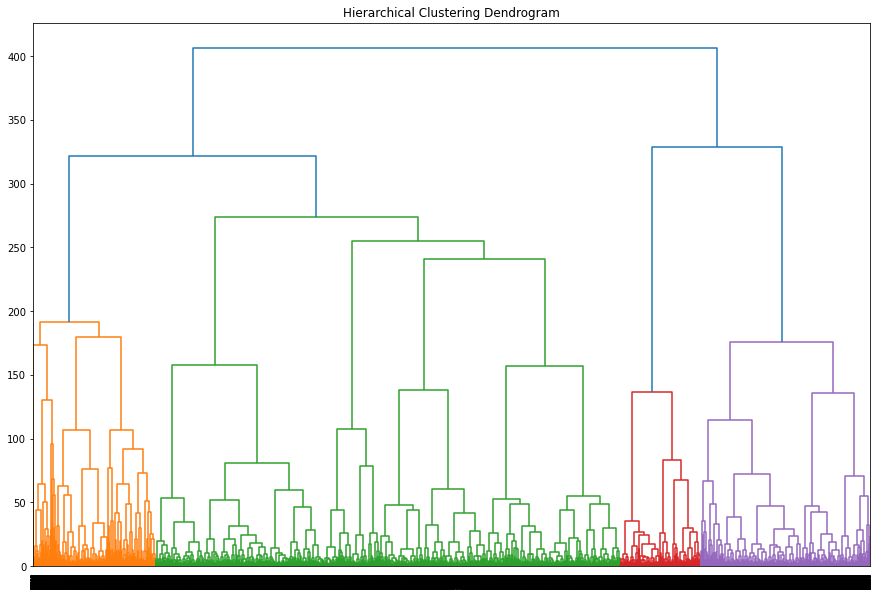

In [11]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
y_pred_agglo = model.fit(charging_sessions_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()